<a href="https://colab.research.google.com/github/mithileshm24iitk/Sentimental_Model/blob/main/Sentimental_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!tar -xzf aclImdb_v1.tar.gz

In [4]:
import os
import pandas as pd

# This function will walk through the data folders and load the reviews
def load_reviews(data_dir):
    reviews = []
    labels = []

    # Loop through 'train' and 'test' folders
    for split in ['train', 'test']:
        split_path = os.path.join(data_dir, split)

        # Loop through 'pos' and 'neg' folders
        for sentiment in ['pos', 'neg']:
            sentiment_path = os.path.join(split_path, sentiment)
            label = 1 if sentiment == 'pos' else 0

            # Loop through all .txt files in the folder
            for filename in os.listdir(sentiment_path):
                if filename.endswith('.txt'):
                    with open(os.path.join(sentiment_path, filename), 'r', encoding='utf-8') as f:
                        reviews.append(f.read())
                        labels.append(label)

    # Create a pandas DataFrame
    df = pd.DataFrame({'review': reviews, 'label': labels})
    return df

# --- Let's run the function ---
data_dir = 'aclImdb'
df = load_reviews(data_dir)

# Print the shape and first 5 rows to see what we've got
print(f"Total reviews loaded: {df.shape[0]}")
print(df.head())

Total reviews loaded: 50000
                                              review  label
0  Personally, I absolutely love this movie and n...      1
1  The young Dr. Fanshawe(Mark Letheren), an avid...      1
2  There are plenty of reviews on this page that ...      1
3  Will Smith delivers yet again in a film about ...      1
4  I came in in the middle of this film so I had ...      1


In [5]:
import re
import nltk
from nltk.corpus import stopwords

# Download the list of stop words from NLTK
# This only needs to be run once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)

    # 2. Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # 3. Convert to lowercase and split into words
    words = text.lower().split()

    # 4. Remove stop words
    #    We keep a word if it's NOT in the stop_words list
    clean_words = [word for word in words if word not in stop_words]

    # 5. Join the words back into a single string
    return ' '.join(clean_words)

# --- Let's apply this function to our 'review' column ---
# This might take about 30-60 seconds to run on all 50,000 reviews
print("Cleaning text... This may take a minute.")

# We create a new column 'cleaned_review'
df['cleaned_review'] = df['review'].apply(clean_text)

# Print the 'head' again to compare
print("Cleaning complete!")
print("\n--- Original vs. Cleaned ---")
print(df[['review', 'cleaned_review']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cleaning text... This may take a minute.
Cleaning complete!

--- Original vs. Cleaned ---
                                              review  \
0  Personally, I absolutely love this movie and n...   
1  The young Dr. Fanshawe(Mark Letheren), an avid...   
2  There are plenty of reviews on this page that ...   
3  Will Smith delivers yet again in a film about ...   
4  I came in in the middle of this film so I had ...   

                                      cleaned_review  
0  personally absolutely love movie novel read bo...  
1  young dr fanshawe mark letheren avid archaeolo...  
2  plenty reviews page explain movie details far ...  
3  smith delivers yet film man weight world shoul...  
4  came middle film idea credits even title till ...  


In [6]:
from sklearn.model_selection import train_test_split

# Define our features (X) and our target (y)
# X is the data we use to predict
X = df['cleaned_review']
# y is what we WANT to predict
y = df['label']

# Split the data
# test_size=0.2 means 20% of the data will be for testing
# random_state=42 ensures we get the same "random" split every time we run this,
# which makes our results reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print the sizes of our new datasets
print(f"Training data size: {X_train.shape[0]}")
print(f"Testing data size: {X_test.shape[0]}")

Training data size: 40000
Testing data size: 10000


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Initialize the vectorizer
# max_features=5000 tells it to only use the 5000 most common words.
# This saves memory (for your 8GB Mac) and often improves results
# by ignoring super-rare, unimportant words.
vectorizer = TfidfVectorizer(max_features=5000)

# 2. Fit and transform the training data
# .fit_transform() learns the vocabulary from X_train and then
# converts X_train into its TF-IDF number matrix.
print("Fitting vectorizer and transforming training data...")
X_train_tfidf = vectorizer.fit_transform(X_train)

# 3. Only transform the testing data
# .transform() uses the *same* vocabulary learned from X_train
# to convert X_test. This prevents "data leakage."
print("Transforming testing data...")
X_test_tfidf = vectorizer.transform(X_test)

# Print the shape of our new data
print("\nShape of our new TF-IDF matrices:")
print(f"X_train_tfidf: {X_train_tfidf.shape}")
print(f"X_test_tfidf: {X_test_tfidf.shape}")

Fitting vectorizer and transforming training data...
Transforming testing data...

Shape of our new TF-IDF matrices:
X_train_tfidf: (40000, 5000)
X_test_tfidf: (10000, 5000)


In [8]:
from sklearn.linear_model import LogisticRegression

# 1. Initialize the model
# We set max_iter=1000 to give it enough time to find the best solution
model = LogisticRegression(max_iter=1000)

# 2. Train the model!
# .fit() is the "training" command.
# It looks at X_train_tfidf and y_train and learns the patterns.
print("Training the model...")
model.fit(X_train_tfidf, y_train)

print("Model training complete!")

Training the model...
Model training complete!


In [9]:
from sklearn.metrics import accuracy_score, classification_report

# 1. Make predictions on the test data
print("Making predictions on the test set...")
y_pred = model.predict(X_test_tfidf)

# 2. Calculate the accuracy
# This compares the model's guesses (y_pred) to the true answers (y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# 3. Print a detailed report
# This shows precision, recall, and f1-score for both classes (0 and 1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

Making predictions on the test set...

Accuracy: 89.00%

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.90      0.88      0.89      4945
Positive (1)       0.88      0.90      0.89      5055

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [10]:
def predict_sentiment(review_text):
    # 1. Clean the new review
    cleaned_review = clean_text(review_text)

    # 2. Vectorize the cleaned review
    # We need to put it in a list [cleaned_review] because
    # the vectorizer expects a collection of texts
    vectorized_review = vectorizer.transform([cleaned_review])

    # 3. Make the prediction
    prediction = model.predict(vectorized_review)

    # 4. Get the probability (how confident the model is)
    probability = model.predict_proba(vectorized_review)

    # 5. Return the result
    if prediction[0] == 1:
        return f"Prediction: Positive 👍 (Confidence: {probability[0][1]*100:.1f}%)"
    else:
        return f"Prediction: Negative 👎 (Confidence: {probability[0][0]*100:.1f}%)"

In [11]:
# --- TEST IT HERE! ---

my_review = "This was a fantastic movie, I really loved the acting!"
print(predict_sentiment(my_review))

my_review_2 = "It was a total waste of time, the plot was boring and predictable."
print(predict_sentiment(my_review_2))

Prediction: Positive 👍 (Confidence: 98.1%)
Prediction: Negative 👎 (Confidence: 100.0%)


# Advanced Neural Network


In [12]:
# Install tensorflow
!pip install -q tensorflow

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Set up our parameters
vocab_size = 10000  # We'll use the top 10,000 most common words
max_length = 250    # We'll cut off/pad all reviews to be 250 words long

# 2. Initialize and fit the tokenizer
# oov_token="<OOV>" adds a special token for "Out of Vocabulary"
# for any words not in our top 10,000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit the tokenizer ONLY on the training data
# This builds the vocabulary
print("Fitting tokenizer on training data...")
tokenizer.fit_on_texts(X_train)

# 3. Convert text to sequences of numbers
print("Converting text to sequences...")
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 4. Pad the sequences
# 'post' means add the padding (zeros) at the end of the sentence
print("Padding sequences...")
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Let's check the new shape
print("\nShape of our new padded data:")
print(f"X_train_pad: {X_train_pad.shape}")
print(f"X_test_pad: {X_test_pad.shape}")

# Let's see what a review looks like now
print("\nOriginal review (from X_train):")
print(X_train.iloc[0])
print("\nSame review as a padded sequence (from X_train_pad):")
print(X_train_pad[0])

Fitting tokenizer on training data...
Converting text to sequences...
Padding sequences...

Shape of our new padded data:
X_train_pad: (40000, 250)
X_test_pad: (10000, 250)

Original review (from X_train):
ernest saves christmas comedian ernest christmas special film film ernest find successor santa claus order christmas continue along way meets young girl thief ends stealing something important santa tell watch film like ernest films lot slapstick humor involved film probably one ernest best films funny important lessons learn regarding friendship family afraid show love best christmas film around good one get christmas spirit little bit sad film little dated

Same review as a padded sequence (from X_train_pad):
[4712 3046  984 2630 4712  984  190    3    3 4712   70    1 2449 6885
  502  984 1541  222   23  746   85  134 2822  524 2670   51  526 2449
  259   28    3    5 4712   30   72 2291  330  429    3  131    4 4712
   40   30   58  526 2750  739 2482 1607  120 1473   39   35   4

In [14]:
import tensorflow as tf

# Define the model
model_nn = tf.keras.Sequential([
    # 1. The Embedding Layer
    # It takes our 10,000-word vocabulary and turns each word into a 128-dimension vector
    # input_length=250 tells it to expect sequences of 250 numbers
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),

    # 2. The LSTM Layer
    # 64 is the number of "memory units." It's a good starting point.
    tf.keras.layers.LSTM(64),

    # 3. A standard "hidden" layer
    # 'relu' is a standard activation function
    tf.keras.layers.Dense(64, activation='relu'),

    # 4. The Output Layer
    # 'sigmoid' activation squashes the output to be a number between 0 (Negative) and 1 (Positive)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 5. Compile the model
# This step configures the model for training
model_nn.compile(
    loss='binary_crossentropy',  # The best "loss function" for a binary (0/1) problem
    optimizer='adam',            # A popular and effective optimizer
    metrics=['accuracy']         # We want to track the accuracy as it trains
)

# 6. Print a summary of the model we just built
model_nn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# We need to make sure y_train and y_test are in the right format
# The .values part converts them from a pandas Series to a numpy array,
# which TensorFlow prefers.
y_train_np = y_train.values
y_test_np = y_test.values

print("Starting model training... This will take a few minutes.")

# --- Train the model ---
history = model_nn.fit(
    X_train_pad,          # The 40,000 padded training reviews
    y_train_np,           # The 40,000 training labels
    epochs=5,             # We'll do 5 full passes over the data
    batch_size=64,        # Process the data in batches of 64 reviews at a time
    validation_split=0.1  # Use 10% of the training data (4,000 reviews) for validation
)

print("\nModel training complete!")

Starting model training... This will take a few minutes.
Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5080 - loss: 0.6921 - val_accuracy: 0.5215 - val_loss: 0.6791
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5315 - loss: 0.6660 - val_accuracy: 0.5220 - val_loss: 0.6797
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5608 - loss: 0.6278 - val_accuracy: 0.8602 - val_loss: 0.3488
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8938 - loss: 0.2703 - val_accuracy: 0.8780 - val_loss: 0.3120
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9419 - loss: 0.1661 - val_accuracy: 0.8783 - val_loss: 0.3262

Model training complete!


In [16]:
print("Evaluating the model on the test set...")

# The model.evaluate() function returns the loss and the metrics (e.g., accuracy)
# We ask for verbose=2 to get a clean, single-line output
loss, accuracy = model_nn.evaluate(X_test_pad, y_test_np, verbose=2)

print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

Evaluating the model on the test set...
313/313 - 2s - 7ms/step - accuracy: 0.8727 - loss: 0.3189

Test Accuracy: 87.27%


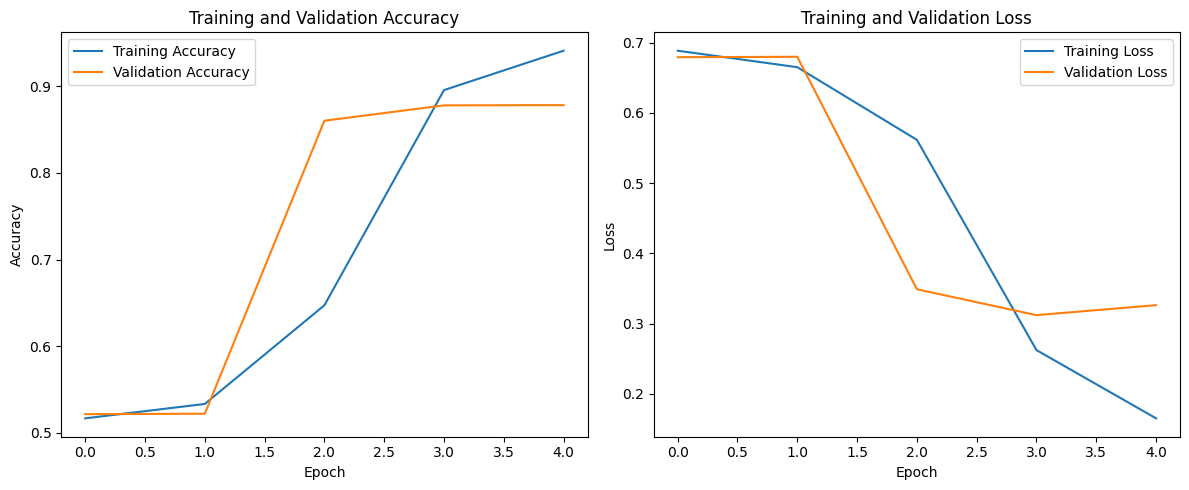

In [17]:
import matplotlib.pyplot as plt

def plot_history(history_data):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_data.history['accuracy'], label='Training Accuracy')
    plt.plot(history_data.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history_data.history['loss'], label='Training Loss')
    plt.plot(history_data.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Plot our model's history ---
plot_history(history)